<center><h1>DSCI-552 Final_Project</h1></center>
<br>
<center><font size="4">Name: Jiade Song    GitHubID: JiadeSong     USCID: 9019610285 </font></center>

<center><font size="4">1. Text Classification</font></center>

In [1]:
import pandas as pd
import numpy as np
import glob
import string
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from tensorflow.keras.layers import Embedding,Input,Dense,Flatten,Dropout,Conv1D,MaxPooling1D,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### (b) Data Exploration and Pre-processing

#### i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.

In [2]:
neg_file_path = r'../../Data/neg'
pos_file_path = r'../../Data/pos'
neg_name_arr = []
pos_name_arr = []
neg_text_arr = []
pos_text_arr = []
neg_cla_arr = []
pos_cla_arr = []

all_neg_files = glob.glob(neg_file_path + "/*.txt")
all_pos_files = glob.glob(pos_file_path + "/*.txt")
for f in all_neg_files:
    neg_name_arr.append(f[(f.find('neg')+4):-4])
    a = open(f, "r")
    neg_text_arr.append(a.read())
    neg_cla_arr.append(0)
    
    
for f in all_pos_files:
    pos_name_arr.append(f[(f.find('pos')+4):-4])
    a = open(f, "r")
    pos_text_arr.append(a.read())
    pos_cla_arr.append(1)
    
name_arr = np.concatenate((neg_name_arr, pos_name_arr))
text_arr = np.concatenate((neg_text_arr, pos_text_arr))
cla_arr = np.concatenate((neg_cla_arr, pos_cla_arr))

### Note: Here I modify the negative class to label as 0 which gives a better performance when training. 

In [3]:
df = pd.DataFrame({'name':name_arr, 'text':text_arr, 'class':cla_arr})
df

,name,text,class
0,cv676_22202,bad . bad . \nbad . \nthat one word seems to p...,0
1,cv839_22807,isn't it the ultimate sign of a movie's cinema...,0
2,cv155_7845,""" gordy "" is not a movie , it is a 90-minute-...",0
3,cv465_23401,disconnect the phone line . \ndon't accept the...,0
4,cv398_17047,when robert forster found himself famous again...,0
...,...,...,...
1995,cv588_13008,one of the funniest carry on movies and the th...,1
1996,cv734_21568,"i remember making a pact , right after `patch ...",1
1997,cv491_12145,barely scrapping by playing at a nyc piano bar...,1
1998,cv647_13691,if the current trends of hollywood filmmaking ...,1


In [4]:
df['text'][1]

'isn\'t it the ultimate sign of a movie\'s cinematic ineptitude when you can\'t think of much to say about it other than " it sucks " ? \none of the first official year 2000 releases , supernova is such a movie . \ni can\'t seem to get past one-word adjectives with this one , although " boring , " " stupid " and " absurd " doesn\'t amount to much of a review . \na shame . \ni would have been able to save myself the chore of desperately trying to elaborate . \nbut c\'est la vie . \nhere goes nothing . \ni\'ll keep it short . \ni suppose the first bad omen for supernova came when director walter hill ( 48 hours ) removed his name from the movie , requesting that it be replaced with the pseudonym thomas lee . \nthe film\'s fate was sealed in many minds when struggling studio mgm declined to screen it for the press , an event usually signifying a studio\'s lack of confidence in a particular movie . \nhill\'s and mgm\'s actions were prudent . \nwhen the captain of medical space vessel night

#### ii. The data are pretty clean. Remove the punctuation and numbers from the data.

In [5]:
for i in range(0,len(df)):
    no_punc = df['text'][i].translate(str.maketrans('', '', string.punctuation))
    no_new_line = no_punc.replace('\n', '')
    no_number = re.sub(r'\d+', '', no_new_line)
    df['text'][i] = no_number
df
#https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-
#from-a-string-in-python-3-x-using-translate

/var/folders/c2/55q5nzv51vz59zgdv6yql13m0000gn/T/ipykernel_29774/3025309946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = no_number


,name,text,class
0,cv676_22202,bad bad bad that one word seems to pretty m...,0
1,cv839_22807,isnt it the ultimate sign of a movies cinemati...,0
2,cv155_7845,gordy is not a movie it is a minutelong s...,0
3,cv465_23401,disconnect the phone line dont accept the cha...,0
4,cv398_17047,when robert forster found himself famous again...,0
...,...,...,...
1995,cv588_13008,one of the funniest carry on movies and the th...,1
1996,cv734_21568,i remember making a pact right after patch ad...,1
1997,cv491_12145,barely scrapping by playing at a nyc piano bar...,1
1998,cv647_13691,if the current trends of hollywood filmmaking ...,1


In [6]:
df['text'][1]

'isnt it the ultimate sign of a movies cinematic ineptitude when you cant think of much to say about it other than  it sucks   one of the first official year  releases  supernova is such a movie  i cant seem to get past oneword adjectives with this one  although  boring    stupid  and  absurd  doesnt amount to much of a review  a shame  i would have been able to save myself the chore of desperately trying to elaborate  but cest la vie  here goes nothing  ill keep it short  i suppose the first bad omen for supernova came when director walter hill   hours  removed his name from the movie  requesting that it be replaced with the pseudonym thomas lee  the films fate was sealed in many minds when struggling studio mgm declined to screen it for the press  an event usually signifying a studios lack of confidence in a particular movie  hills and mgms actions were prudent  when the captain of medical space vessel nightingale dies in a tragic hyperjump accident  a reformed drug addict who is als

#### iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [7]:
train_df = pd.DataFrame({'name':[],'text':[],'class':[]})
test_df = pd.DataFrame({'name':[],'text':[],'class':[]})
for i in range(0,len(df)):
    if int(df['name'][i][2:5]) <=  699:
        train_df.loc[len(train_df.index)] = df.iloc[i]
    else:
        test_df.loc[len(test_df.index)] = df.iloc[i]

In [8]:
train_df

,name,text,class
0,cv676_22202,bad bad bad that one word seems to pretty m...,0.0
1,cv155_7845,gordy is not a movie it is a minutelong s...,0.0
2,cv465_23401,disconnect the phone line dont accept the cha...,0.0
3,cv398_17047,when robert forster found himself famous again...,0.0
4,cv206_15893,this is my first review that i post to this ne...,0.0
...,...,...,...
1395,cv033_24444,in wonder boys michael douglas plays an aged w...,1.0
1396,cv588_13008,one of the funniest carry on movies and the th...,1.0
1397,cv491_12145,barely scrapping by playing at a nyc piano bar...,1.0
1398,cv647_13691,if the current trends of hollywood filmmaking ...,1.0


#### iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [9]:
results = set()
df['text'].str.lower().str.split().apply(results.update)
len(results)

46830

#### Answer: Number of unique words is 46830.

#### v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [10]:
train_len = []
print('The row number of training set is: ' + str(len(train_df)))
for i in range(0,len(train_df)):
    result_len = len(train_df['text'][i].split())
    train_len.append(result_len)

print('The average review length of training text is: ' + str(np.mean(train_len)))
print('The review length std of training text is: ' + str(np.std(train_len)))
print('---------------------------------------------------------------')
test_len = []
print('The row number of testing set is: ' + str(len(test_df)))
for i in range(0,len(test_df)):
    result_len = len(test_df['text'][i].split())
    test_len.append(result_len)
    
print('The average review length of testing text is: ' + str(np.mean(test_len)))
print('The review length std of testing text is: ' + str(np.std(test_len)))
print('---------------------------------------------------------------')
print('The average review length of whole text set is: ' + str(((np.mean(test_len))\
                                                                *600+(np.mean(train_len))*1400)/2000))
all_len = train_len+test_len
print('The review length std of whole text set is: ' + str(np.std(all_len)))


The row number of training set is: 1400
The average review length of training text is: 641.4178571428571
The review length std of training text is: 285.0965181848464
---------------------------------------------------------------
The row number of testing set is: 600
The average review length of testing text is: 651.21
The review length std of testing text is: 284.5896096135627
---------------------------------------------------------------
The average review length of whole text set is: 644.3555
The review length std of whole text set is: 284.97987142910637


#### vi. Plot the histogram of review lengths.

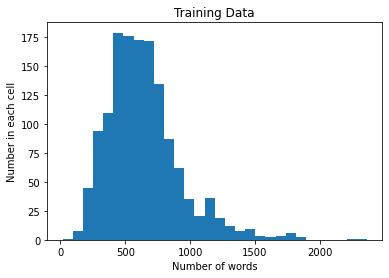

In [11]:
plt.hist(train_len, density=False, bins=30)
plt.ylabel('Number in each cell')
plt.xlabel('Number of words')
plt.title('Training Data');

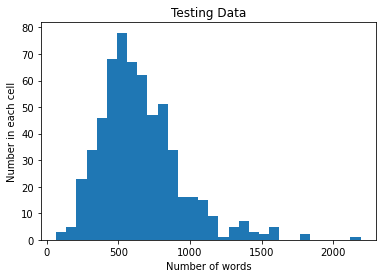

In [12]:
plt.hist(test_len, density=False, bins=30)
plt.ylabel('Number in each cell')
plt.xlabel('Number of words')
plt.title('Testing Data');

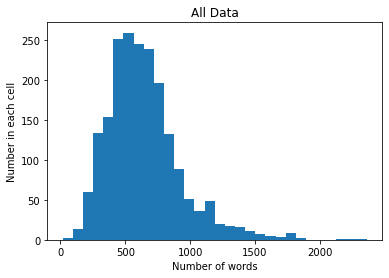

In [13]:
plt.hist(all_len, density=False, bins=30)
plt.ylabel('Number in each cell')
plt.xlabel('Number of words')
plt.title('All Data');

#### vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [14]:
tok  = Tokenizer(num_words = 5001)

tok.fit_on_texts(train_df['text'])

In [15]:
print("The rank of words",dict(list(tok.word_index.items())[:30]) )

The rank of words {'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'as': 10, 'with': 11, 'for': 12, 'his': 13, 'this': 14, 'film': 15, 'but': 16, 'he': 17, 'i': 18, 'on': 19, 'are': 20, 'by': 21, 'its': 22, 'be': 23, 'an': 24, 'one': 25, 'not': 26, 'who': 27, 'movie': 28, 'at': 29, 'was': 30}


In [16]:
train_df['text']

0       bad  bad  bad  that one word seems to pretty m...
1         gordy  is not a movie  it is a minutelong  s...
2       disconnect the phone line  dont accept the cha...
3       when robert forster found himself famous again...
4       this is my first review that i post to this ne...
                              ...                        
1395    in wonder boys michael douglas plays an aged w...
1396    one of the funniest carry on movies and the th...
1397    barely scrapping by playing at a nyc piano bar...
1398    if the current trends of hollywood filmmaking ...
1399    capsule  the director of cure brings a weird a...
Name: text, Length: 1400, dtype: object

In [17]:
tokenized_train = tok.texts_to_sequences(train_df['text'])
tokenized_test = tok.texts_to_sequences(test_df['text'])

In [18]:
train_df['token'] = tokenized_train
test_df['token'] = tokenized_test
test_df

,name,text,class,token
0,cv839_22807,isnt it the ultimate sign of a movies cinemati...,0.0,"[170, 9, 1, 1779, 1646, 4, 2, 107, 1120, 43, 3..."
1,cv756_23676,jet li busted onto the american action movie s...,0.0,"[2816, 2768, 1218, 1, 249, 131, 28, 103, 43, 1..."
2,cv823_17055,starring shawnee smith donovan leitch ricky ...,0.0,"[724, 708, 3000, 431, 2673, 1153, 1, 6, 1, 161..."
3,cv747_18189,in s many european intellectuals especially ...,0.0,"[7, 125, 116, 296, 142, 19, 1, 317, 894, 1347,..."
4,cv948_25870,and just when you thought joblo was getting a ...,0.0,"[3, 50, 43, 34, 347, 3955, 30, 334, 2, 92, 325..."
...,...,...,...,...
595,cv736_23670,the premise of the new teentargeted horror fil...,1.0,"[1, 643, 4, 1, 114, 320, 15, 349, 2601, 2349, ..."
596,cv873_18636,in roger michells romantic comedy notting hill...,1.0,"[7, 1542, 555, 181, 1522, 786, 1963, 605, 2, 2..."
597,cv957_8737,capsule the best place to start if youre a ja...,1.0,"[2436, 1, 108, 233, 5, 452, 51, 401, 2, 488, 1..."
598,cv804_10862,satirical films usually fall into one of two c...,1.0,"[3855, 66, 624, 585, 53, 25, 4, 80, 1723, 99, ..."


#### viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [19]:
L = np.percentile(train_len, 70)
L

730.3

Answer: the 70% of the length is 730. 

In [20]:
train_len = []
train_token = []
Selected_len = []
Selected_name = []
Selected_text = []
Selected_class = []
Selected_token = []
print('The row number of training set is: ' + str(len(train_df)))
for i in range(0,len(train_df)):
    result_len = len(train_df['text'][i].split())
    if result_len <= L:
        Selected_len.append(result_len)
        Selected_text.append(train_df['text'][i])
        Selected_name.append(train_df['name'][i])
        Selected_class.append(train_df['class'][i])
        Selected_token.append(train_df['token'][i])
    train_len.append(result_len)

The row number of training set is: 1400


In [21]:
Selected_train_df = pd.DataFrame({'name':Selected_name, 'text':Selected_text, 'class':Selected_class,\
                                  'token':Selected_token,'len':Selected_len})
Selected_train_df

,name,text,class,token,len
0,cv155_7845,gordy is not a movie it is a minutelong s...,0.0,"[6, 26, 2, 28, 9, 6, 2, 1177, 3, 2, 77, 104, 2...",480
1,cv465_23401,disconnect the phone line dont accept the cha...,0.0,"[1, 1720, 336, 119, 1771, 1, 4791, 75, 230, 34...",611
2,cv398_17047,when robert forster found himself famous again...,0.0,"[43, 518, 4567, 369, 218, 1043, 211, 82, 3016,...",391
3,cv206_15893,this is my first review that i post to this ne...,0.0,"[14, 6, 106, 78, 440, 8, 18, 4179, 5, 14, 3, 1...",437
4,cv037_19798,lake placid marks yet another entry in the ...,0.0,"[2321, 2929, 238, 126, 2682, 7, 1, 271, 4, 8, ...",513
...,...,...,...,...,...
975,cv254_6027,curdled is a deliciously dark and witty black ...,1.0,"[6, 2, 4901, 409, 3, 1366, 301, 181, 16, 22, 1...",636
976,cv576_14094,as fairy tales go cinderella has to be one of...,1.0,"[10, 2421, 3042, 127, 33, 5, 23, 25, 4, 1, 63,...",561
977,cv588_13008,one of the funniest carry on movies and the th...,1.0,"[25, 4, 1, 2233, 1022, 19, 107, 3, 1, 772, 11,...",439
978,cv491_12145,barely scrapping by playing at a nyc piano bar...,1.0,"[1263, 21, 354, 29, 2, 3615, 1933, 1237, 5, 13...",354


##### the df table above is the text length larger than 730 (980 rows, 70 percentile), which is not the whole data to train. 

#### ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [22]:
train_pad = pad_sequences(train_df['token'], maxlen = 730)
test_pad = pad_sequences(test_df['token'], maxlen = 730)

In [23]:
cut_tokens = []
for i in range(0,len(train_pad)):
    cut_tokens.append(train_pad[i])

cut_tokens2 = []
for i in range(0,len(test_pad)):
    cut_tokens2.append(test_pad[i])

In [24]:
train_df['cut_tokens'] = cut_tokens
test_df['cut_tokens'] = cut_tokens2
test_df

,name,text,class,token,cut_tokens
0,cv839_22807,isnt it the ultimate sign of a movies cinemati...,0.0,"[170, 9, 1, 1779, 1646, 4, 2, 107, 1120, 43, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,cv756_23676,jet li busted onto the american action movie s...,0.0,"[2816, 2768, 1218, 1, 249, 131, 28, 103, 43, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,cv823_17055,starring shawnee smith donovan leitch ricky ...,0.0,"[724, 708, 3000, 431, 2673, 1153, 1, 6, 1, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,cv747_18189,in s many european intellectuals especially ...,0.0,"[7, 125, 116, 296, 142, 19, 1, 317, 894, 1347,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,cv948_25870,and just when you thought joblo was getting a ...,0.0,"[3, 50, 43, 34, 347, 3955, 30, 334, 2, 92, 325...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
595,cv736_23670,the premise of the new teentargeted horror fil...,1.0,"[1, 643, 4, 1, 114, 320, 15, 349, 2601, 2349, ...","[8, 91, 989, 139, 52, 65, 53, 2, 2997, 4, 732,..."
596,cv873_18636,in roger michells romantic comedy notting hill...,1.0,"[7, 1542, 555, 181, 1522, 786, 1963, 605, 2, 2...","[279, 1, 78, 951, 224, 4, 15, 3, 44, 109, 82, ..."
597,cv957_8737,capsule the best place to start if youre a ja...,1.0,"[2436, 1, 108, 233, 5, 452, 51, 401, 2, 488, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
598,cv804_10862,satirical films usually fall into one of two c...,1.0,"[3855, 66, 624, 585, 53, 25, 4, 80, 1723, 99, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### (c) Word Embeddings

#### i. One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.”4. Most deep learning modules (including Keras) provide a convenient way to convert positive integer rep- resentations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are inter- ested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document.5 If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × 500 matrix.

In [25]:
model = keras.Sequential()

2022-05-11 02:56:14.377277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
embedding_layer = Embedding(5001, 32, input_length=730)
model.add(embedding_layer)


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 730, 32)           160032    
                                                                 
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________


#### ii. Flatten the matrix of each document to a vector.

In [28]:
model.add(Flatten())

### (d) Multi-Layer Perceptron

#### i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [29]:
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.20))
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.50))
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.50))

In [30]:
model.add(Dense(1,activation='sigmoid'))

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [32]:
# input1=Input(shape=(len(train_df),730),dtype='float64')

In [33]:

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 730, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 23360)             0         
                                                                 
 dense (Dense)               (None, 50)                1168050   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

In [34]:
train_pad

array([[   1,   15,    9, ..., 4174,   11, 1842],
       [   0,    0,    0, ...,   81,   71, 1575],
       [   0,    0,    0, ...,   31,    1,  486],
       ...,
       [   0,    0,    0, ...,   92,   89,  394],
       [   0,    0,    0, ..., 1634,    7,    9],
       [   0,    0,    0, ...,    1,    5, 1628]], dtype=int32)

In [35]:
model.predict(train_pad)

array([[0.49939263],
       [0.49669516],
       [0.4982751 ],
       ...,
       [0.49682048],
       [0.49310458],
       [0.49402043]], dtype=float32)

In [36]:
model.fit(train_pad, train_df['class'], epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 2s 7ms/step - loss: 0.6984 - acc: 0.5057
Epoch 2/2
140/140 [==============================] - 1s 7ms/step - loss: 0.6609 - acc: 0.5907


#### ii. Report the train and test accuracies of this model.

In [37]:
model.evaluate(test_pad,  test_df['class'])

19/19 [==============================] - 0s 2ms/step - loss: 0.6701 - acc: 0.5883


[0.6700639724731445, 0.5883333086967468]

In [38]:
model.evaluate(train_pad,  train_df['class'])

44/44 [==============================] - 0s 3ms/step - loss: 0.4339 - acc: 0.9136


[0.43386614322662354, 0.9135714173316956]

#### The train accuracy is 0.80 (mostly) and test accuracy is 0.55 (mostly) for 2 epochs but not stable.
#### The train accuracy is 0.99 and test accuracy is 0.7100 for 3 epochs. After 3 epochs, the test accuracy decreases. (Overfitting)
#### With number of epochsof 5 the training acc decreases to 64%
#### With number of epochs larger than 10 the training acc decreases to 63%

### (e) One-Dimensional Convolutional Neural Network: 
#### Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

#### i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [39]:
model = keras.Sequential()
embedding_layer = Embedding(5001, 32, input_length=730)
model.add(embedding_layer)
model.add(Conv1D(32,3,input_shape=(None, 730, 32)))
model.add(MaxPooling1D(pool_size = 2,strides = 2))
model.add(Flatten())
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.20))
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.50))
model.add(Dense(50,activation='ReLU'))
model.add(Dropout(0.50))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 730, 32)           160032    
                                                                 
 conv1d (Conv1D)             (None, 728, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 364, 32)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 11648)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                582450    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [40]:
model.fit(train_pad, train_df['class'], epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 2s 12ms/step - loss: 0.7010 - acc: 0.5157
Epoch 2/2
140/140 [==============================] - 2s 12ms/step - loss: 0.6875 - acc: 0.5371


#### ii. Report the train and test accuracies of this model.

In [41]:
model.evaluate(train_pad,  train_df['class'])

44/44 [==============================] - 0s 3ms/step - loss: 0.6223 - acc: 0.8093


[0.6223115921020508, 0.8092857003211975]

In [42]:
model.evaluate(test_pad,  test_df['class'])

19/19 [==============================] - 0s 3ms/step - loss: 0.6805 - acc: 0.5883


[0.6805057525634766, 0.5883333086967468]

#### The train accuracy is 0.85 and test accuracy is 0.55 for 2 epochs (mostly, but not stable). 
#### The train accuracy is 0.9971 and test accuracy is 0.6800 for 4 epochs. 
#### The train accuracy is 1.0000 and test accuracy is 0.7700 for 10 epochs. 
#### The train accuracy is 1.0000 and test accuracy is 0.7983 for 25 epochs. 

### (f) Long Short-Term Memory Recurrent Neural Network:
#### The structure of the LSTM we are going to use is shown in the following figure.

#### i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [43]:
model = keras.Sequential()
embedding_layer = Embedding(5001, 32, input_length=730)
model.add(embedding_layer)

# model.add(Flatten())
model.add(LSTM(32))
model.add(Dropout(0.20))
model.add(Dense(256,activation='ReLU'))
model.add(Dropout(0.20))


model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 730, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-tr

In [44]:
model.fit(train_pad, train_df['class'], epochs=20, batch_size=10)

Epoch 1/20
140/140 [==============================] - 20s 132ms/step - loss: 0.6908 - acc: 0.5286
Epoch 2/20
140/140 [==============================] - 17s 121ms/step - loss: 0.5243 - acc: 0.7693
Epoch 3/20
140/140 [==============================] - 17s 118ms/step - loss: 0.1848 - acc: 0.9343
Epoch 4/20
140/140 [==============================] - 19s 133ms/step - loss: 0.0863 - acc: 0.9714
Epoch 5/20
140/140 [==============================] - 17s 121ms/step - loss: 0.0614 - acc: 0.9807
Epoch 6/20
140/140 [==============================] - 16s 115ms/step - loss: 0.1321 - acc: 0.9536
Epoch 7/20
140/140 [==============================] - 16s 118ms/step - loss: 0.0203 - acc: 0.9921
Epoch 8/20
140/140 [==============================] - 17s 122ms/step - loss: 0.0061 - acc: 0.9979
Epoch 9/20
140/140 [==============================] - 17s 122ms/step - loss: 0.0011 - acc: 1.0000
Epoch 10/20
140/140 [==============================] - 18s 128ms/step - loss: 4.9761e-04 - acc: 1.0000
Epoch 11/20
140

#### ii. Report the train and test accuracies of this model.

In [45]:
model.evaluate(train_pad,  train_df['class'])

44/44 [==============================] - 2s 32ms/step - loss: 2.4240e-05 - acc: 1.0000


[2.424046215310227e-05, 1.0]

In [46]:
model.evaluate(test_pad,  test_df['class'])

19/19 [==============================] - 1s 31ms/step - loss: 1.6201 - acc: 0.7650


[1.620126485824585, 0.7649999856948853]

#### The train accuracy is 1.0000 and test accuracy is 0.7700 after 25 epochs. 

#### The training accuracy is close to one after about 6-7 epochs, which means there is a probability of overfitting. In this situation, I would slightly modify this model in the following to add a early stop to determine the number of epochs and see if the test accuracy would increase. 

In [47]:
model = keras.Sequential()
embedding_layer = Embedding(5001, 32, input_length=730)
model.add(embedding_layer)

# model.add(Flatten())
model.add(LSTM(32))
model.add(Dropout(0.20))
model.add(Dense(256,activation='ReLU'))
model.add(Dropout(0.20))

callback = EarlyStopping(monitor='loss', patience=3)
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'],)
print(model.summary())
model.fit(train_pad, train_df['class'], epochs=50, batch_size=10, callbacks=[callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 730, 32)           160032    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 256)               8448      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-tr

In [48]:
model.evaluate(test_pad,  test_df['class'])

19/19 [==============================] - 1s 48ms/step - loss: 2.3737 - acc: 0.7667


[2.3737261295318604, 0.7666666507720947]

#### Here, after I ran the model for several times with different number of epochs, the test accuracy increases slowly (from 74% to about 78%) if I increased the number of epochs from  6 to 50. I would guess the test accuracy would keep increasing after 50 epochs. Also, in most situation, the early stop with 3 patience rarely make effects. This may because the model is slowly inproving and getting stable.